In [1]:
!nvidia-smi

Wed Jul 13 19:55:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:17:00.0 Off |                  N/A |
|  0%   35C    P8    12W / 250W |   5506MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:65:00.0 Off |                  N/A |
| 36%   59C    P2    66W / 250W |    971MiB / 11176MiB |     16%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
import h5py
import numpy as np

path = '/home/tahaei/SA_Source/'
# save_path = '/media/external_3TB/3TB/yousefi/'

ap = ['passive', 'active']
actives = [119, 121, 122, 121, 117, 117, 122, 116, 121, 121, 119, 124, 120, 118, 120, 123, 119, 123, 119]
passives = [124, 99, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124]
count2 = 0

size = 1200

X = []
Y = []
S = []

count2 = -1
datatmp = np.array([])
for subject in range(1, 11):
    print(subject)
    if subject == 12:
        continue
    count2 += 1
    for n in range(2):
        filepath = path + 'SubjS' + str(subject) + '.mat'
        # print(filepath)
        # print(ap[n])
        f = h5py.File(filepath, 'r')

        data = f['SourceAAL'][ap[n]]
        aptmp = 1
        if n == 1:
            aptmp = actives[count2]
        if n == 0:
            aptmp = passives[count2]

        for i in range(aptmp):

            tmp = data[i][0]
            sf = f[tmp]
            sf = np.array(sf)
            sf = np.reshape(sf, (1200))
            datapart = np.array([sf])
            for j in range(116):
                if j == 0:
                    continue
                tmp = data[i][j]
                sf = f[tmp]
                sf = np.array(sf)
                sf = np.reshape(sf, (1200))
                datapart = np.concatenate((datapart, [sf]), axis=0)

            if i == 0:
                datatmp = np.array([datapart])

            else:
                datatmp = np.concatenate((datatmp, [datapart]), axis=0)

        #  datatmp.shape = aptmp, 116, size
        X.append(datatmp)
        Y.append(np.ones(datatmp.shape[0]) * n)
        S.append(np.ones(datatmp.shape[0]) * subject)

X = np.concatenate(X)
Y = np.concatenate(Y)
S = np.concatenate(S)
# np.save('X.npy', X)
# np.save('Y.npy', Y)
# np.save('S.npy', S)


1
2
3
4
5
6
7
8
9
10


In [3]:
np.save('X.npy', X)
np.save('Y.npy', Y)
np.save('S.npy', S)

In [37]:
import numpy as np
X = np.load('X.npy')
Y = np.load('Y.npy')
S = np.load('S.npy')
X.shape

(2412, 116, 1200)

In [38]:
X = X.reshape((X.shape[0], 1, X.shape[1], X.shape[2]))
X.shape

(2412, 1, 116, 1200)

In [39]:
mean = X.mean(axis=0)
std = X.std(axis=0)

X = X - mean
X = X / std

print("Done")

Done


In [40]:
Y[600:650]
S[600:650]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [4]:
merged_train_x = X.reshape(X.shape[0], -1)
merged_train_x.shape

(2655, 139200)

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=300)
merged_train_x = pca.fit_transform(merged_train_x)
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(merged_train_x)
x_tsne.shape

(2655, 2)

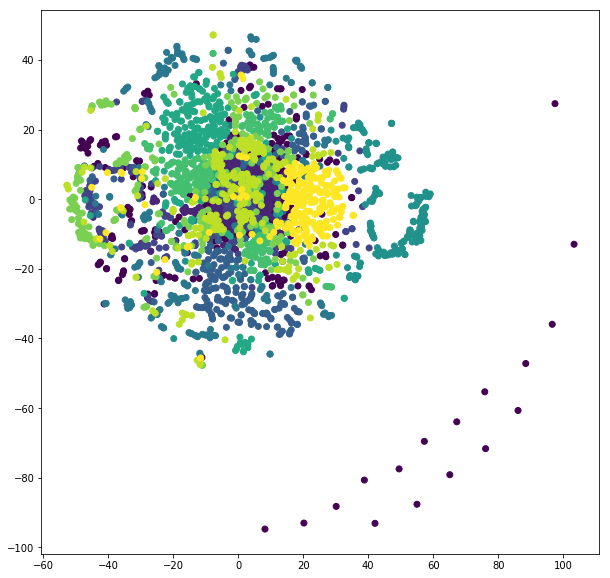

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=S)
plt.show()

In [35]:
X.shape

(2655, 1, 116, 1200)

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os

In [42]:
from torch import nn


class Model(nn.Module):
    def __init__(self, num_classes, verbose=False):
        super().__init__()
        self.verbose = verbose
        self.representation_size = 1400
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.conv1_1 = nn.Conv2d(1, 10, (5, 11), (1, 2))
        self.bn1_1 = nn.BatchNorm2d(10)
        self.conv1_2 = nn.Conv2d(10, 10, (5, 10), (1, 2))
        self.bn1_2 = nn.BatchNorm2d(10)
        self.conv1_3 = nn.Conv2d(10, 10, (5, 10), (1, 2))
        self.bn1_3 = nn.BatchNorm2d(10)

        self.conv2_1 = nn.Conv2d(10, 20, 5, stride=(2,2))
        self.bn2_1 = nn.BatchNorm2d(20)
        self.conv2_2 = nn.Conv2d(20, 20, 5, stride=(2,2))
        self.bn2_2 = nn.BatchNorm2d(20)
        self.conv2_3 = nn.Conv2d(20, 40, 5, stride=(2,2))
        self.bn2_3 = nn.BatchNorm2d(40)
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(self.representation_size, 512)
        self.dropout = nn.Dropout2d(.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):  # 32, 384
        x = self.conv1_1(x)  # 28, 187
        if self.verbose:
            print(x.size())
        x = self.bn1_1(x)
        x = self.relu(x)
        x = self.conv1_2(x)  # 24, 89
        if self.verbose:
            print(x.size())
        x = self.bn1_2(x)
        x = self.relu(x)
        x = self.conv1_3(x)  # 20, 40
        if self.verbose:
            print(x.size())
        x = self.bn1_3(x)
        x = self.relu(x)

        x = self.conv2_1(x)  # 16, 36
        if self.verbose:
            print(x.size())
        x = self.bn2_1(x)
        x = self.relu(x)
        x = self.conv2_2(x)  # 12, 32
        if self.verbose:
            print(x.size())
        x = self.bn2_2(x)
        x = self.relu(x)
        x = self.conv2_3(x)  # 8, 28
        if self.verbose:
            print(x.size())
        x = self.bn2_3(x)
        x = self.relu(x)

        x = self.pool2(x)  # 4, 14
        if self.verbose:
            print(x.size())

        x = x.view(-1, self.representation_size)
        if self.verbose:
            print(x.size())

        x = self.fc1(x)
        x = self.tanh(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


if __name__ == '__main__':
    import torch
    a = torch.randn([3, 1, 116, 1200])
    m = Model(2, True)
    b = m(torch.from_numpy(X[:5]).float())
#     b = m(a)
    print(b)


torch.Size([5, 10, 112, 595])
torch.Size([5, 10, 108, 293])
torch.Size([5, 10, 104, 142])
torch.Size([5, 20, 50, 69])
torch.Size([5, 20, 23, 33])
torch.Size([5, 40, 10, 15])
torch.Size([5, 40, 5, 7])
torch.Size([5, 1400])
tensor([[-0.1670, -0.0200],
        [-0.0416, -0.0463],
        [-0.1139, -0.1032],
        [-0.6422, -0.2828],
        [ 0.1447, -0.2614]], grad_fn=<AddmmBackward>)


In [9]:
from sklearn.model_selection import train_test_split
data = train_test_split(X, Y, S, test_size=0.2, random_state=0, shuffle=True)
data_train_x = data[0]
data_test_x = data[1]
data_train_y = data[2]
data_test_y = data[3]
data_train_s = data[4]
data_test_s = data[5]
# for i in range(len(data_train_s)):
#     data_train_s[i] -= 1

In [43]:
data_train_x = X[S != 7]
data_test_x = X[S == 7]
data_train_y = Y[S != 7]
data_test_y = Y[S == 7]
data_train_s = S[S != 7]
data_test_s = S[S == 7]
for i in range(len(data_train_s)):
    if data_train_s[i] > 7:
        data_train_s[i] -= 1
for i in range(len(data_test_s)):
    if data_test_s[i] > 7:
        data_test_s[i] -= 1     
for i in range(len(data_train_s)):
    data_train_s[i] -= 1

In [10]:
print(data_train_x.shape)
print(data_train_s.shape)

(2166, 1, 116, 1200)
(2166,)


In [66]:
batch_size = 128
learning_rate = 0.0001
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [67]:
model = Model(2).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [68]:
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
train_dataset = TensorDataset(torch.from_numpy(data_train_x).float(), torch.from_numpy(data_train_y).long(), torch.from_numpy(data_train_s).long())
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = TensorDataset(torch.from_numpy(data_test_x).float(), torch.from_numpy(data_test_y).long(), torch.from_numpy(data_test_s).long())
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [69]:
import numpy as np
unique, counts = np.unique(data_train_s, return_counts=True)
dict(zip(unique, counts))

{0.0: 243,
 1.0: 220,
 2.0: 246,
 3.0: 245,
 4.0: 241,
 5.0: 241,
 6.0: 240,
 7.0: 245,
 8.0: 245}

In [70]:
from tqdm import tqdm
for epoch in range(num_epochs):

    for batch_idx, (data, main_targets, batch_targets) in enumerate(train_loader):
        
        data = data.to(device)
        targets = main_targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    scheduler.step()
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y, z in test_loader:
            
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    print(f"Test Accuracy:{num_correct.item()/num_samples}")
    model.train()
    

Test Accuracy:0.5040650406504065
Test Accuracy:0.532520325203252
Test Accuracy:0.5121951219512195
Test Accuracy:0.5772357723577236
Test Accuracy:0.5284552845528455
Test Accuracy:0.508130081300813
Test Accuracy:0.5284552845528455
Test Accuracy:0.5609756097560976
Test Accuracy:0.4959349593495935
Test Accuracy:0.483739837398374


In [16]:
def prepare_output(dim, target_label):
    out = torch.zeros((dim, 32))
    for i in range(len(out)):
        out[i][target_label] = 10
    return out

def change_outputs(out, target_label):
    for i in range(len(out)):
        out[i][target_label] = 500
    return out

def pgd_attack(model, images, labels, eps, iters):
    alpha = 2 / 255
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
#     outputs = prepare_output(len(class_labels), 0).to(device)
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)
#         outputs = change_outputs(outputs, 0)


        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
#         images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        images = (ori_images + eta).detach_()
            
    return images

In [19]:
import numpy as np
model.eval()

correct = 0
total = 0
i = 0
fes = None

for images, class_labels, batch_labels in train_loader:
    
    images = pgd_attack(model, images, batch_labels, eps=10/255, iters=8)
    batch_labels = batch_labels.to(device)
    outputs = model(images)

    
    _, pre = torch.max(outputs.data, 1)

    total += len(batch_labels)
    correct += (pre == batch_labels).sum()
    
    data_train_x = np.vstack((data_train_x, images.to(device="cpu").numpy()))
    data_train_y = np.concatenate((data_train_y, class_labels.to(device="cpu").numpy()))
    data_train_s = np.concatenate((data_train_s, batch_labels.to(device="cpu").numpy()))
    
    print(i)
    i += 1


print('Accuracy of Model Againest Adversarial Examples: %f %%' % (100 * float(correct) / total))
# torch.max(model(fes), 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Accuracy of Model Againest Adversarial Examples: 32.271468 %


In [20]:
adversarial_train_x = data_train_x[len(data_train_x) // 2:]
adversarial_train_y = data_train_y[len(data_train_y) // 2:]
adversarial_train_s = data_train_s[len(data_train_s) // 2:]

In [21]:
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
train_dataset = TensorDataset(torch.from_numpy(adversarial_train_x).float(), torch.from_numpy(adversarial_train_y).long(), torch.from_numpy(adversarial_train_s).long())
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = TensorDataset(torch.from_numpy(data_test_x).float(), torch.from_numpy(data_test_y).long(), torch.from_numpy(data_test_s).long())
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [22]:
num_correct = 0
num_samples = 0
model.eval()

with torch.no_grad():
    for x, y, z in train_loader:

        x = x.to(device)
        z = z.to(device)

        scores = model(x)
        _, predictions = scores.max(1)
        num_correct += (predictions == z).sum()
        num_samples += predictions.size(0)

print(f"Accuracy:{num_correct.item()/num_samples}")

Accuracy:0.32271468144044324


In [35]:
data_train_y.shape

(4818,)

In [23]:
merged_train_x = adversarial_train_x.reshape(adversarial_train_x.shape[0], -1)
merged_train_x.shape

(2166, 139200)

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# pca = PCA(n_components=300)
# merged_train_x = pca.fit_transform(merged_train_x)
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(merged_train_x)
x_tsne.shape

(2166, 2)

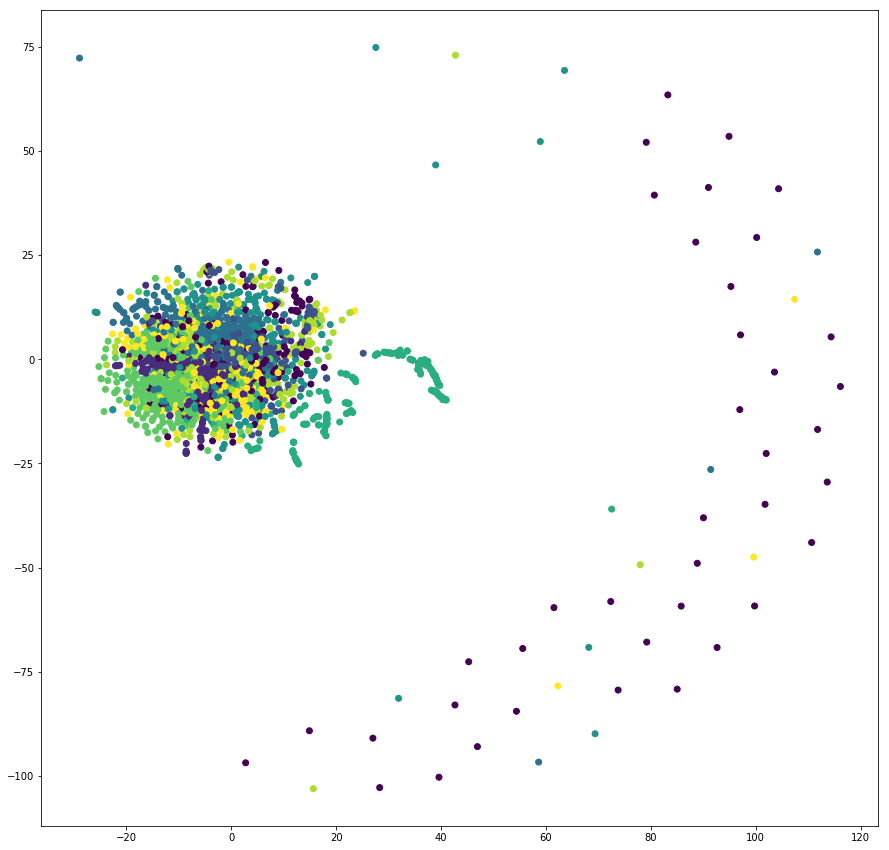

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,15))
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=adversarial_train_s)
plt.show()

In [80]:
batch_size = 128
learning_rate = 0.001
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [81]:
model = Model(2).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [82]:
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
train_dataset = TensorDataset(torch.from_numpy(adversarial_train_x).float(), torch.from_numpy(adversarial_train_y).long(), torch.from_numpy(adversarial_train_s).long())
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataset = TensorDataset(torch.from_numpy(data_test_x).float(), torch.from_numpy(data_test_y).long(), torch.from_numpy(data_test_s).long())
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

<div dir="rtl">
    <h3>
  حالت درهم
    </h3>
   </div>

In [ ]:
from tqdm import tqdm
for epoch in range(num_epochs):

    for batch_idx, (data, main_targets, batch_targets) in enumerate(train_loader):
        
        data = data.to(device)
        targets = main_targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    scheduler.step()
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y, z in test_loader:
            
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    print(f"Epoch: {epoch} ---- Accuracy:{num_correct.item()/num_samples}")
    model.train()
    

<div dir="rtl">
    <h3>
  حالت کنارگذاشتن یکی از دسته ها
    </h3>
   </div>

In [83]:
from tqdm import tqdm
for epoch in range(num_epochs):

    for batch_idx, (data, main_targets, batch_targets) in enumerate(train_loader):
        
        data = data.to(device)
        targets = main_targets.to(device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    
    scheduler.step()
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y, z in test_loader:
            
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    print(f"Epoch: {epoch} ---- Accuracy:{num_correct.item()/num_samples}")
    model.train()
    

Epoch: 0 ---- Accuracy:0.5203252032520326
Epoch: 1 ---- Accuracy:0.483739837398374
Epoch: 2 ---- Accuracy:0.4959349593495935
Epoch: 3 ---- Accuracy:0.47560975609756095
Epoch: 4 ---- Accuracy:0.4959349593495935
Epoch: 5 ---- Accuracy:0.46747967479674796
Epoch: 6 ---- Accuracy:0.556910569105691
Epoch: 7 ---- Accuracy:0.6788617886178862
Epoch: 8 ---- Accuracy:0.5040650406504065
Epoch: 9 ---- Accuracy:0.508130081300813
Epoch: 10 ---- Accuracy:0.5528455284552846
Epoch: 11 ---- Accuracy:0.5365853658536586
Epoch: 12 ---- Accuracy:0.573170731707317
Epoch: 13 ---- Accuracy:0.5609756097560976
Epoch: 14 ---- Accuracy:0.5528455284552846
Epoch: 15 ---- Accuracy:0.5813008130081301
Epoch: 16 ---- Accuracy:0.5691056910569106
Epoch: 17 ---- Accuracy:0.5691056910569106
Epoch: 18 ---- Accuracy:0.5609756097560976
Epoch: 19 ---- Accuracy:0.573170731707317
